In [1]:
from typing import TypeAlias
import math

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from tqdm import tqdm

import random

In [2]:
np.random.seed(0)

In [3]:
Sample: TypeAlias = list[int | float]
Data: TypeAlias = list[Sample]

Target: TypeAlias = int | float
Targets: TypeAlias = list[Target]

Weights: TypeAlias = list[list[float]]

In [4]:
# Activation functions

from abc import ABC, abstractmethod


class ActivationBase(ABC):
    @abstractmethod
    def calc(self, x: Sample) -> list[float]:
        """Apply the activation function to an layer output"""
        pass

    @abstractmethod
    def derivative(self, x: Sample):
        pass

#######################################


class ReLU(ActivationBase):
    def calc(self, x: Sample) -> list[float]:
        return np.maximum(0, x)

    def derivative(self, x: Sample):
        return self.calc(x=x)


class Sigmoid(ActivationBase):
    def calc(self, x: Sample) -> list[float]:
        x = np.clip(x, -500, 500)
    
        return np.where(
            x >= 0,
            1 / (1 + np.exp(-x)),
            np.exp(x) / (1 + np.exp(x))
        )

    def derivative(self, x: Sample):
        f = self.calc(x=x)
        return f * (1 - f)


class Empty(ActivationBase):
    def calc(self, x: Sample):
        return x
    def derivative(self, x: Sample):
        return x


class Softmax(ActivationBase):
    """returns model 'probabilities' for each class"""

    def calc(self, x: Sample) -> list[float]:
        # optimization: make numbers in an array from -inf to 0 because of a np.exp growing
        # and returns an array of floats from 0.0 to 1.0
        max_value = np.max(x)
        x -= max_value

        exp_values = np.exp(x)
        return exp_values / np.sum(exp_values)
    
    def derivative(self, x: Sample):
        pass

In [5]:
# Loss functions

class LossBase(ABC):
    @abstractmethod
    def calc(self, x: Sample, y: Target) -> float:
        """Apply the loss function to an output layer"""
        pass


class MSELoss(LossBase):
    """For regression""" 
    def calc(self, x: Sample, y: Target) -> float:
        loss = (y - x) * 0.5
        return np.mean(loss)


class CrossEntropy(LossBase):
    """For classification"""
    def calc(self, x: Sample, y: Targets) -> float:
        return -np.sum(y * np.log(x))

In [6]:
class Dataset:
    def __init__(self, data: Data, targets: Targets) -> None:
        self.data: Data = data
        self._len = len(data)
        self.targets: Targets = targets

    def __len__(self) -> int:
        return self._len

    def __getitem__(self, index) -> Sample:
        return self.data[index]

    def __iter__(self):
        return iter(self.data)

In [342]:
class Linear:
    def __init__(self, n_inputs: int, n_neurons: int, activation: ActivationBase = None) -> None:
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons

        self.weights = self._init_weights()
        self.bias = self._init_bias()
        self.output = []

        self.activation = activation

    def _init_weights(self) -> list[float]:
        weights = np.random.randn(self.n_neurons, self.n_inputs) * np.sqrt(2. / self.n_inputs)
        for i in range(len(weights)):
            for j in range(len(weights[i])):
                weights[i][j] += random.randint(1, 10)
        return weights

    def _init_bias(self) -> list[float]:
        return np.random.randn(self.n_neurons, 1)

    def forward(self, inputs) -> None:
        output_list = []
        for neuron in range(self.n_neurons):
            output = 0
            for i in range(len(self.weights[neuron])):
                output += self.weights[neuron][i] * inputs[i]
            output_list.append(output)
        output_list = np.array(output_list)
        output_list += self.bias.flatten()
        self.output = self.activation.calc(output_list)

    def backward(self, delta: list[float], call_derivative: bool = True) -> list[float]:
        new_deltas = []
        for i in range(len(self.weights)):
            for j in range(len(self.weights[i])):
                new_delta = np.clip(self.weights[i][j] * delta[0][i], -0.1, 0.1)
                if call_derivative:
                    new_delta *= self.activation.derivative(self.output[i])
                new_deltas.append(new_delta)
        new_deltas = np.array(new_deltas)
        return new_deltas

    def update_weights(self, delta: list[float], learning_rate: float) -> None:
        for i in range(len(self.weights)):
            for j in range(len(self.weights[i])):
                self.weights[i][j] += np.clip(delta[0][i] * self.output[i] * learning_rate, -500, 500)

        for i in range(len(self.bias)):
            self.bias[i] += delta[0][i] * learning_rate

Layers: TypeAlias = list[Linear]

In [490]:
class Model:
    def __init__(self, layers: Layers, loss: LossBase, regression: bool = True):
        self.layers = layers
        self._layers_len = len(layers)
        self.loss = loss
        self.regression = regression

    def fit(self, dataset: Dataset, n_epoch: int = 1, learning_rate: float = 0.01, verbose: bool = True) -> list[float]:
        losses_by_epoch = []

        range_epoch = range(n_epoch)
        if verbose:
            range_epoch = tqdm(range_epoch, desc="epochs", position=0)

        for epoch in range_epoch:
            epoch_losses = []

            for i,sample in enumerate(dataset):
                sample = np.array(sample)

                # Forward pass
                self.layers[0].forward(inputs=sample) # input layer
                for j in range(1, self._layers_len):
                    self.layers[j].forward(inputs=self.layers[j-1].output)

                target = dataset.targets[i]

                # Calc loss
                output_error = self.calc_loss(target=target)
                epoch_losses.append(output_error)

                # Backward pass
                delta_list = []
                delta = [output_error for _ in range(self.layers[-1].n_neurons)]
                delta_list.append([delta])
                if self.regression:
                    delta = self.layers[-1].backward(delta=delta_list[-1], call_derivative=True)
                else:
                    delta = self.layers[-1].backward(delta=delta_list[-1], call_derivative=False)
                delta_list.append([delta])

                for i in range(self._layers_len - 2, -1, -1):
                    delta = self.layers[i].backward(delta=delta_list[-1])
                    delta_list.append([delta])

                # Update weights
                delta_list = delta_list[::-1]
                for i in range(self._layers_len):
                   self.layers[i].update_weights(delta=delta_list[i], learning_rate=learning_rate)

            mean_loss = np.mean(epoch_losses)
            losses_by_epoch.append(mean_loss)

        return losses_by_epoch

    def predict(self, sample: Sample) -> float:
        sample = np.array(sample)

        self.layers[0].forward(inputs=sample)
        for i in range(1, self._layers_len):
            self.layers[i].forward(inputs=self.layers[i-1].output)
        if self.regression:
            return np.mean(self.layers[-1].output)
        else:
            return np.argmax(self.layers[-1].output)

    def predict_proba(self, sample: Sample) -> list[float]:
        sample = np.array(sample)

        self.layers[0].forward(inputs=sample)
        for i in range(1, self._layers_len):
            self.layers[i].forward(inputs=self.layers[i-1].output)
        return self.layers[-1].output

    def calc_loss(self, target: Target) -> float:
        output_layer = self.layers[-1]
        output = output_layer.output

        loss = self.loss.calc(x=output, y=target)
        return loss

    def set_weights(self, weights: Weights) -> None:
        for w,layer in zip(weights, self.layers):
            layer.weights = w

    @property
    def weights(self) -> Weights:
        weights = [layer.weights for layer in self.layers]
        return weights

## Dataset

In [9]:
X = sorted(np.random.uniform(0, 10, 500))
y = [math.cos(x) for x in X]

X = np.array(X)
X = X.reshape(-1, 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0)

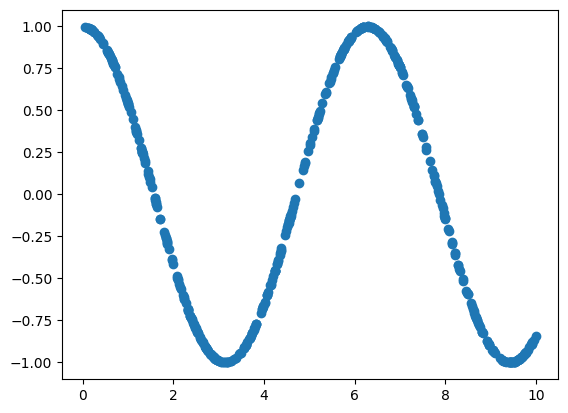

In [344]:
plt.plot(X, y, 'o')
plt.show()

In [ ]:
train_dataset = Dataset(data=X_train, targets=y_train)

layers = [
    Linear(1,20, activation=Sigmoid()),
    Linear(20,1, activation=Empty()),
]

model = Model(layers=layers, loss=MSELoss(), regression=True)


losses = model.fit(dataset=train_dataset, n_epoch=1, learning_rate=0.001, verbose=1)

epochs: 100%|██████████| 10/10 [00:00<00:00, 27.84it/s]


In [553]:
losses

[-2.7463231223936675]

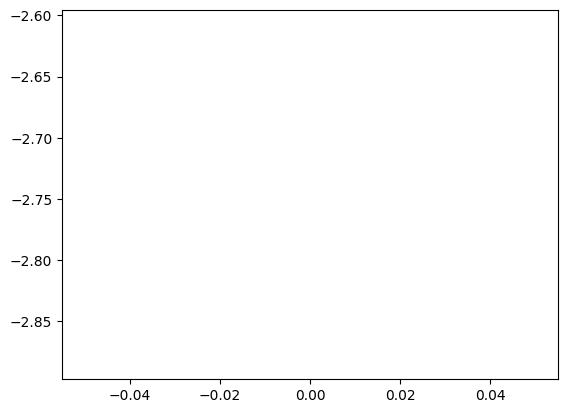

In [554]:
plt.plot(losses)
plt.show()

In [13]:
preds = []
for i in X_val:
    pred = model.predict(i)
    preds.append(pred)

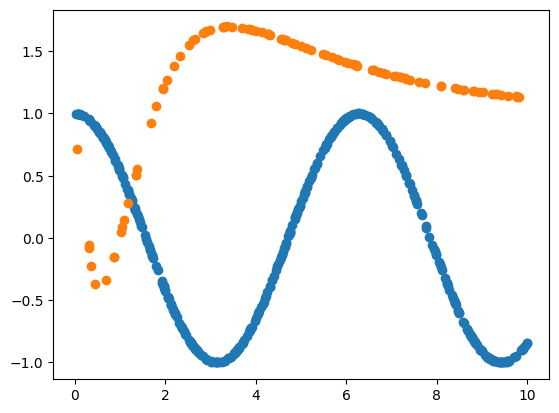

In [552]:
plt.plot(X_train, y_train, 'o')
plt.plot(X_val, preds, 'o')
plt.show()

# LinearRegression

In [2515]:
from sklearn.linear_model import LinearRegression

In [966]:
sklearn_X_train = np.array(X_train)
sklearn_X_train = sklearn_X_train.reshape(-1, 1)

sklearn_y_val = np.array(y_val)
sklearn_y_val = sklearn_y_val.reshape(-1, 1)

In [2832]:
sklearn_model = LinearRegression().fit(sklearn_X_train, y_train)

In [2833]:
sklearn_preds = sklearn_model.predict(sklearn_y_val)

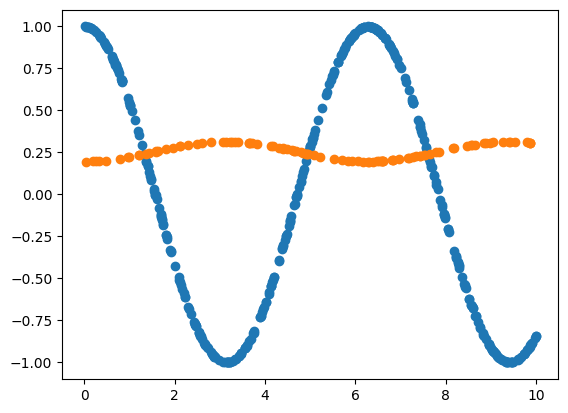

In [2834]:
plt.plot(sklearn_X_train, y_train, 'o')
plt.plot(X_val, sklearn_preds, 'o')
plt.show()

# MLPRegressor

In [967]:
from sklearn.neural_network import MLPRegressor

In [977]:
sklearn_model = MLPRegressor(random_state=0).fit(sklearn_X_train, y_train)

/Users/phil/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [978]:
sklearn_preds = sklearn_model.predict(sklearn_y_val)

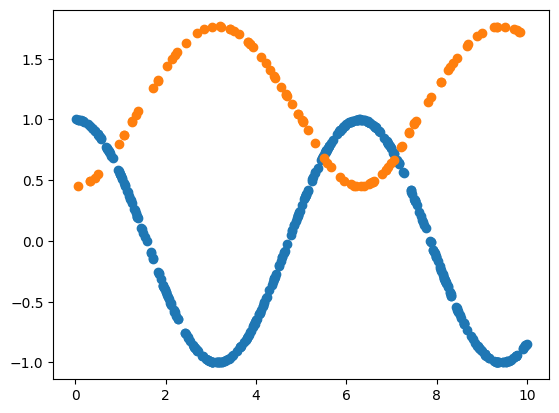

In [979]:
plt.plot(sklearn_X_train, y_train, 'o')
plt.plot(X_val, sklearn_preds, 'o')
plt.show()

# Make Moons dataset

In [450]:
from sklearn.datasets import make_moons

In [451]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)

y = list(y)
for i in range(len(y)):
    if y[i] == 0:
        y[i] = np.array([1, 0])
    elif y[i] == 1:
        y[i] = np.array([0, 1])

In [452]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0)

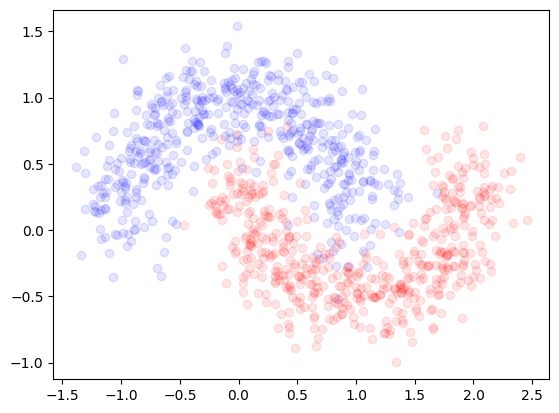

In [453]:
class_1_X = []
class_2_X = []

class_1_y = []
class_2_y = []

class_1_color = "blue"
class_2_color = "red"

for i in range(len(y)):
    if list(y[i]) == [1, 0]:
        class_1_X.append(X[i][0])
        class_1_y.append(X[i][1])
    elif list(y[i]) == [0, 1]:
        class_2_X.append(X[i][0])
        class_2_y.append(X[i][1])
    

plt.plot(class_1_X, class_1_y, 'o', color=class_1_color, alpha=0.1)
plt.plot(class_2_X, class_2_y, 'o', color=class_2_color, alpha=0.1)
plt.show()

In [454]:
train_dataset = Dataset(data=X_train, targets=y_train)

layers = [
    Linear(2,20, activation=Sigmoid()),
    Linear(20,2, activation=Softmax()),
]

model = Model(layers=layers, loss=CrossEntropy(), regression=False)

losses = model.fit(dataset=train_dataset, n_epoch=1, learning_rate=0.00001, verbose=1)

epochs: 100%|██████████| 10/10 [00:02<00:00,  4.68it/s]


In [455]:
losses

[0.6469764351388855]

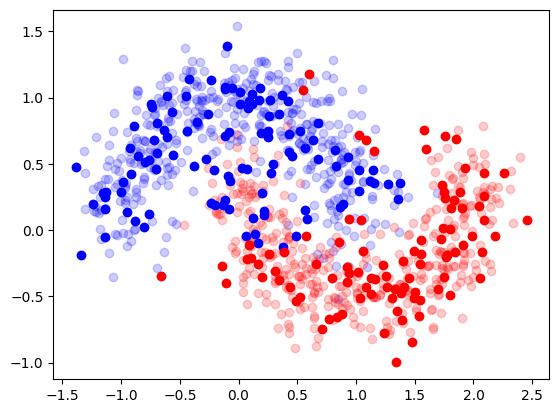

In [424]:
class_1_X_test = []
class_2_X_test = []

class_1_y_test = []
class_2_y_test = []

for i in X_val:
    pred = model.predict(i)
    if pred == 0:
        class_1_X_test.append(i[0])
        class_1_y_test.append(i[1])
    elif pred == 1:
        class_2_X_test.append(i[0])
        class_2_y_test.append(i[1])

plt.plot(class_1_X, class_1_y, 'o', color=class_1_color, alpha=0.2)
plt.plot(class_2_X, class_2_y, 'o', color=class_2_color, alpha=0.2)
plt.plot(class_1_X_test, class_1_y_test, 'o', color=class_1_color, alpha=1)
plt.plot(class_2_X_test, class_2_y_test, 'o', color=class_2_color, alpha=1)
plt.show()

# MNIST dataset

In [95]:
from sklearn.datasets import load_digits

In [227]:
dataset = load_digits(n_class=10)

In [228]:
X, y = dataset.data, dataset.target

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0)

y_one_hot = list(y_train)
for i in range(len(y_train)):
    if y_train[i] == 0:
        y_one_hot[i] = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    elif y_train[i] == 1:
        y_one_hot[i] = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
    elif y_train[i] == 2:
        y_one_hot[i] = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
    elif y_train[i] == 3:
        y_one_hot[i] = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
    elif y_train[i] == 4:
        y_one_hot[i] = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
    elif y_train[i] == 5:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
    elif y_train[i] == 6:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
    elif y_train[i] == 7:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
    elif y_train[i] == 8:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
    elif y_train[i] == 9:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

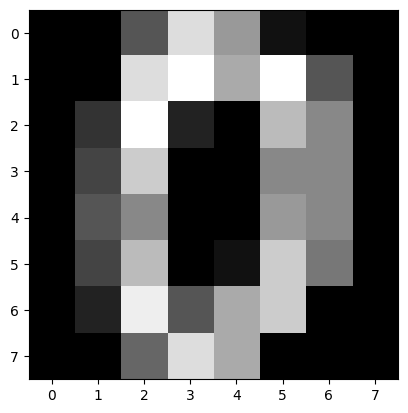

In [220]:
plt.imshow(X[0].reshape(8,8), cmap='gray')
plt.show()

In [ ]:
train_dataset = Dataset(data=X_train, targets=y_train)

layers = [
    Linear(8*8,10, activation=Sigmoid()),
    Linear(10,10, activation=Softmax()),
]

model = Model(layers=layers, loss=CrossEntropy(), regression=False)

losses = model.fit(dataset=train_dataset, n_epoch=1, learning_rate=0.1, verbose=1)

epochs: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


In [222]:
preds = []
for i in X_val:
    pred = model.predict(i)
    preds.append(pred)

In [1]:
print(preds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
accuracy_score(y_true=y_val, y_pred=preds)

0.075